<a href="https://colab.research.google.com/github/mahmouddraz/xai/blob/main/XAI_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SHAP: **Shapley** **Additive** Explaination, Some theory befor we start. 

It is part of the **feature relevance methods** where the approach tries to approximate the effect of each feature on the model prediction by giving each feature a relevance score. 
How to measure the relevance score? Several methods can be used. Shapelly values is one of this methods which will be used by SHAP. 


**Who is Shappely? and What are the Shapley Values?**



*   Shapely values comes form game theory. 

* It an stastically estimated value that measure how much a member of group contributed to a value producded collaborativlly.  
* For this tutorial, we will provide explain what you need to know from the game theory. 
* If you are not familar with game theory, the [wikibedia](https://en.wikipedia.org/wiki/Game_theory) page provides suffincet information you need. 




**What does additive mean?**

How much feature I contribute to the prediction, this called attribution of $i$.
then why it is called additive: you will now in a minute 

If we have a group $C$ working together to deliver output $V$, how much did each individual contribute to that value?

What is the fair value of each contributor to overall value of the whole product? This is called the Shapley value for this contributor. 


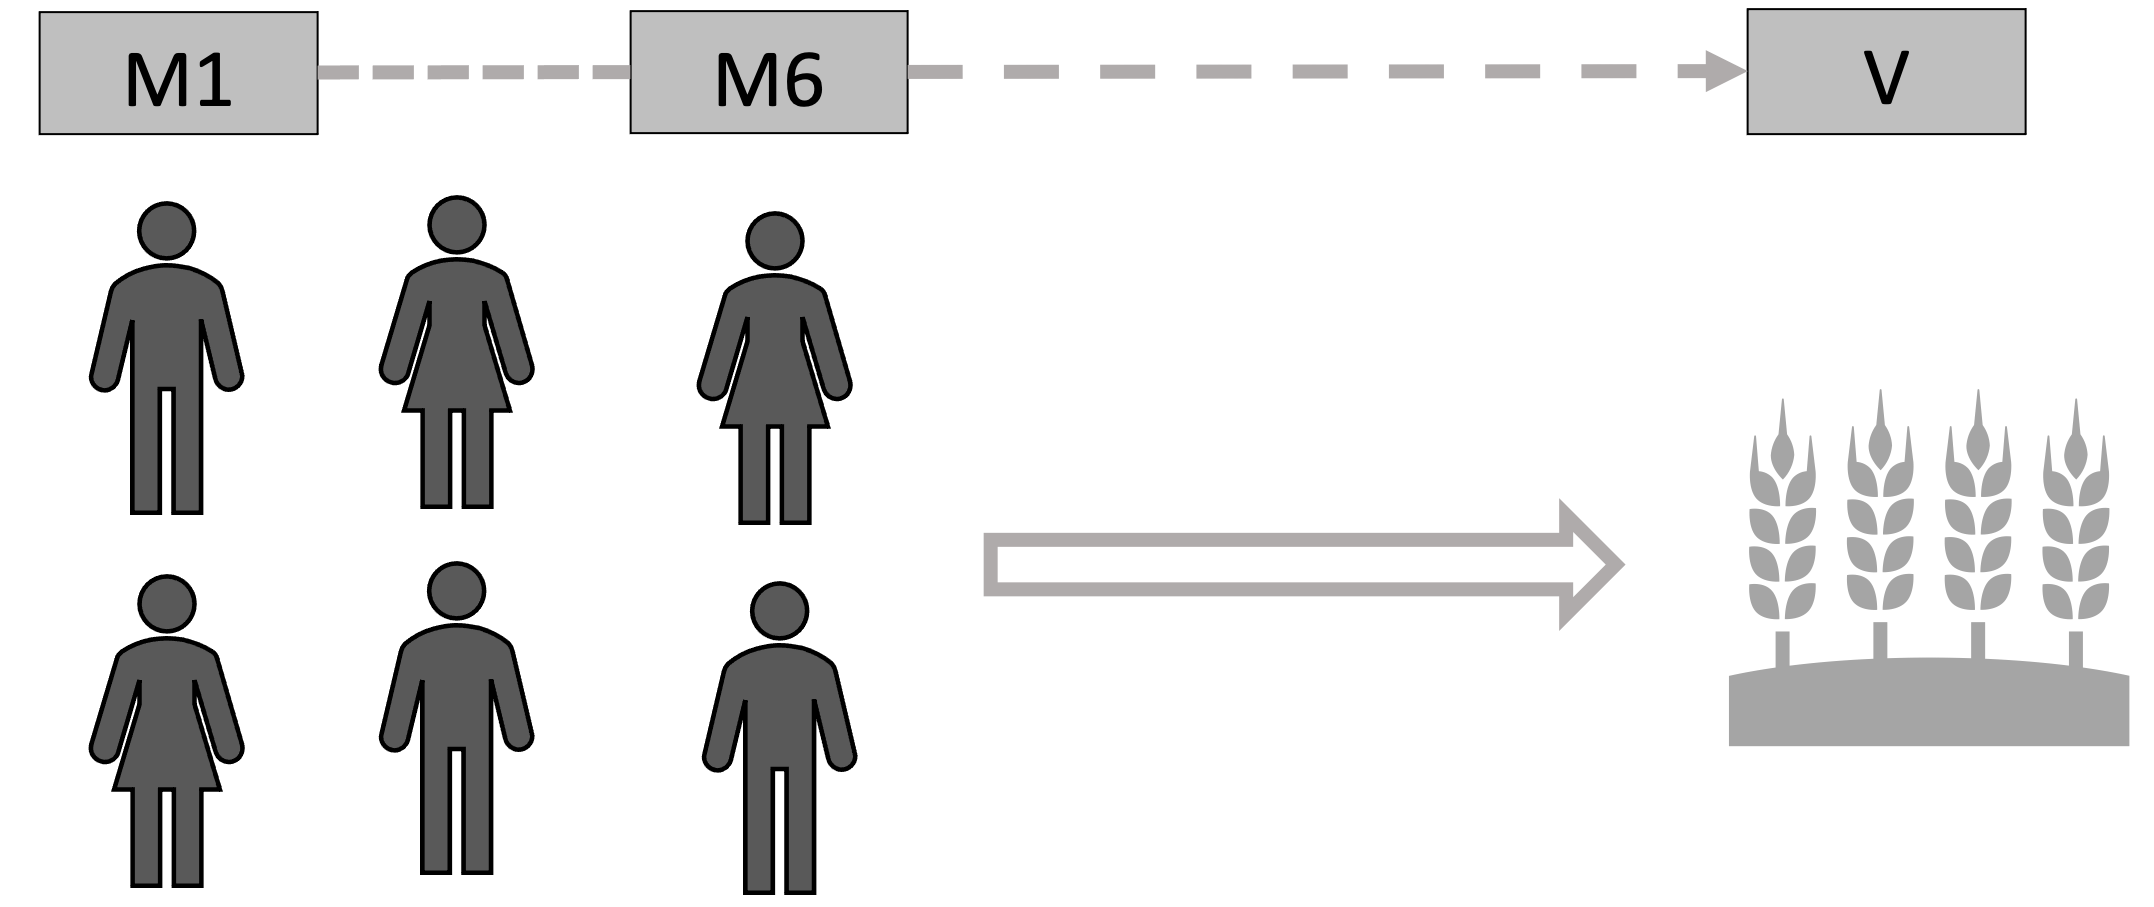


**How Shappely values are calculated?

If would like to calculate the shapely value for member 1: 
1.	Sample a subset $C$ group of several members where member 1 is part of 
2.	Calculate the value of that this subset produces (let’s call this $V’$)
3.	Take out member 1 form the the subset
4.	Calculate overall value the coalition produce without member 1
5.	Compare it to the original value of overall product (Member 1 value = $V-V’$) (Marginal contribution of member one)
6.	Sample a new subest and repeat steps $2 – 5$ 
7.	Do step $6$ for all possible subsets 
8.	Take the mean of the produced $V’$ values, this will be the Shapley value for member 1. Let’s call it $Φ_i$  
9.	Smame for other members, repeat steps $1 - 8$, we can get $Φ$ values for each member. 



......... ** ......... ** ......... ** ......... ** ......... ** ......... ** ..



 **$Φ_i =  \frac{1}{N} \sum_{m=0}^{Z} \frac{M_i}{len(C)}$** 
 
 **Where**: 
* $M_i$: the marginal contribution of member $i$; 
* $N$: is the total number of the members in the group; 
* $Z$: is the number of the subsets;  
* $C$: subset of the group $∀ C, st. i ∉ C$.

## How Shapely method can used to explain the prediction of an AI/ML model?



The goal is to find a function **$g$** that takes the ML model and its training data sets and returns importancee scores (think about the shapely values here) for the features contained in the data sets. 

## How the explainable model is formulated?


Here comes the imporance of work from [Lundenberg and Lee: A Unified Approach to Interpreting Model Predictions](https://arxiv.org/abs/1705.07874): 

......... ** ......... ** ......... ** ......... ** ......... ** ......... ** ........ 

**$g(x') = \phi_{0} + \sum_{i=0}^{N} \phi_{i} x'$** \\

.... $Φ_0$ .... + .... $Φ_1$ .... + .... $Φ_2$ .... \\
.... $P_0$ .... + .... $P_1$ .... + .... $P_2$ ....

That is why it is called additive. 

**We need define anotations**

* $X$: The set of features (e.g., pixels in image or salary of an employee for the credits approval prediction problem); 

* $f(x)$: The prediction model; 

* $X’$: simplified set of features (basically feature vector is replaced by a binary one with values $1$ or $0$ where $1$ means the feature considered and $0$ otherwise); 

* $g$: Explanatory model that calculates the contribution of $X’, \backepsilon g(x’) ≈ f(x)  ⃒ x \approx x’ $; 

* $Ø_i$: The effect that a feature makes on the model prediction (the Shapley value); 

* $N$: is the number of simplified features in an example (e.g., pixels in image or salary, address etc..of an employee for the credits approval prediction problem). 

* $\phi_0$: the average output of the model; if the model know nothing about the specsific. where $X'$ are set to $0$.

* $\phi_i$:  is shapely value of feature $i$.  


## How it works: 


* Set the binary feature vector to $0$, you get $Φ_0$. 

* One by one, set the features in the feature vector to $1$, 
and record the effect on the total change in model prediction. 

* Add up all the affects to get a breakdown of how each feature contributed positively or negatively to the final prediction. 

# The issue with method 

You need to have all possible subsets to calculate shapely value for each feature, and this is very time-consuming task.

## Probelm

In [ ]:
# The number of runs increases exponentially 
features = 10
runs = features ** (features -1)
runs

1000000000

## SHAP kernel

we do not have to take all possibilities; we run enough number and estimate shapely value using a weighted linear regression model. 

* Take subset of the training datasets -- $S$; 

* Take the features included in this dataset; 

* Apply the original model $f$ to all possible $j$ number of subsets ($C$) of this selected features; 

* Now you created a dataset consists of subsets of combinations $C$ and related prediction $Y’$; 

* Assign weight for each combination of features $C$, $W_c = \frac{N -1}{len(C) * Len(C=1) * len(C=0)}$; 

* Build a weighted linear regression model $ ∅_i = Y × W_c $ to estimate Shapely values for all features. 




# Let's practice 

## Install SHAP

In [ ]:
pip install shap

 # SHAP health-care stork datasets.

In [103]:
import shap 
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt
from sklearn.compose import make_column_transformer, ColumnTransformer
import pickle

In [ ]:
url = 'https://raw.githubusercontent.com/deepfindr/xai-series/master/data/healthcare-dataset-stroke-data.csv'

strok_data_sets_raw = pd.read_csv(url)
strok_data_sets_raw = strok_data_sets_raw.dropna()
strok_data_sets_raw

In [ ]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(strok_data_sets_raw.drop(['stroke'], axis=1), strok_data_sets_raw['stroke'], test_size=0.2, random_state=0)


# Data Preprocessing 

In [ ]:
from sklearn.pipeline import make_pipeline 
from sklearn.pipeline import Pipeline 

In [ ]:
categorical_features = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
numeric_features = ["id", "age", "hypertension", "avg_glucose_level", "bmi", "heart_disease"]

column_trans = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_features), remainder="passthrough"
    )

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Model 1: Random Forest

In [ ]:
model_clf = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0)

In [ ]:
clf_pipe_line = Pipeline(steps=[('preprocessor', preprocessor), ('model', model_clf)])

In [ ]:
clf_pipe_line.fit(X_train, y_train)

In [ ]:
y_pred = clf_pipe_line.predict(X_test)

In [ ]:
X_test_en = column_trans.fit(X_test)

In [ ]:
column_trans.transformers_[1][2]

In [ ]:
# evaluate model
print('Accuracy Score:')
print(str(round(accuracy_score(y_test, y_pred) * 100 , 2)) + ' %')

Save model

In [ ]:
import pickle

In [35]:
def save_model(model):
  with open("%s.pickle" % model, "wb") as f: 
        pickle.dump(model, file=f)

In [38]:
def upload_model(model): 
  with open("%s.pickle" % model, "rb") as f: 
        return pickle.load(f)

In [ ]:
y_pred = clf_pipe_line.predict(X_test)

In [ ]:
print('Accuracy Score:')
print(str(round(accuracy_score(y_test, y_pred) * 100 , 2)) + ' %')

Accuracy Score:
95.62 %


In [ ]:
cat_features = clf_pipe_line['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)

In [ ]:
num_features = clf_pipe_line['preprocessor'].transformers_[0][1]['scaler'].get_feature_names_out(numeric_features)

In [ ]:
feature_names= cat_features.tolist() + num_features.tolist()
feature_names

# Encoding 

In [ ]:
X_test_encoded = clf_pipe_line['preprocessor'].transform(X_test)
X_train_encoded = clf_pipe_line['preprocessor'].transform(X_train)

# Utils

In [ ]:
def make_explainer(model, X):
    '''
    make SHAP explainer for the health-care stork datasets.
    '''
    explainer = shap.TreeExplainer(model, model_output='raw', feature_perturbation='interventional', data=X)
    return explainer

def get_shap_values(explainer, X):
    '''
    make shap values for the health-care stork datasets.
    '''
    shap_values = explainer.shap_values(X)
    return shap_values
  
def get_shap_interaction_values(explainer, X):
    '''
    get shap interaction values from the the explainer
    '''
    shap_interaction_values = explainer.shap_interaction_values(X)
    return shap_interaction_values

In [ ]:
explainer = make_explainer(clf_pipe_line['model'], X_test_encoded)

In [ ]:
### SHAPPlots ###
def make_shap_summary_plot(shap_values, X, feature_names, max_display=10):
    '''
    make shap summary plot 
    '''
    return shap.summary_plot(shap_values, features=feature_names, max_display=max_display)

def make_force_plot(explainer, shap_values, feature_names, class_=0):
  shap.initjs()
  return shap.force_plot(explainer.expected_value[class_], shap_values[class_][:1], feature_names=feature_names) 

def make_shap_dependence_plot(ind, shap_values, X, feature_names, interaction_index):
    '''
    make shap dependence plot 
    '''
    return shap.dependence_plot(ind=ind, interaction_index=interaction_index, shap_values=shap_values, features=X, feature_names=feature_names)

## Calculate Shap Values

In [ ]:
shap_values_ = explainer.shap_values(X_test_encoded)

 95%|=================== | 1872/1964 [00:15<00:00]       

# Summary Plot

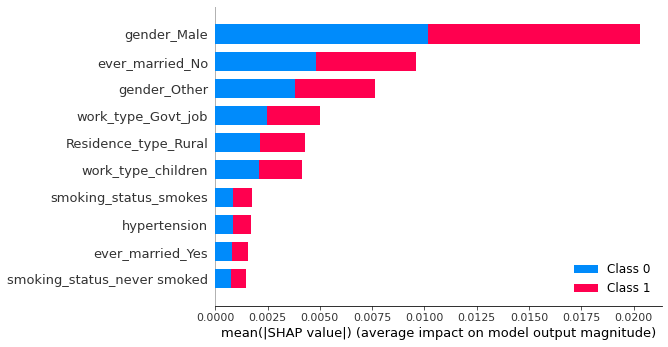

In [ ]:
make_shap_summary_plot(shap_values=shap_values_, X=X_test_encoded, feature_names=feature_names)

# Force Plot

In [ ]:
make_force_plot(explainer=explainer, feature_names=feature_names, class_=1)

# Dependence Plot 

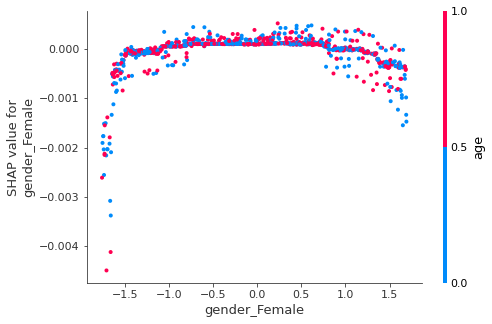

In [ ]:
make_shap_dependence_plot(ind=0, interaction_index="age", shap_values=shap_values_[0], X=X_test_encoded, feature_names=feature_names)

# SHAP for image modality: CAT VS DOG

In [ ]:
!pip install --upgrade tensorflow

In [9]:
'''
Tensfor for the Cat vs. dog probelm
'''
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


In [79]:
split = ['train[:70%]', 'train[70%:]']
class_names = ['cat', 'dog']

#Only if the URL in tensorflow fails
#setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [80]:
# load the dataset
dataset, info = tfds.load('cats_vs_dogs', split=split, as_supervised=True, with_info=True)

In [ ]:
tfds.show_examples(dataset[1], info)

In [81]:
# split the dataset into training and testing
train_dataset, test_dataset = dataset[0], dataset[1]

# get the number of classes
num_classes = info.features['label'].num_classes

# get the number of training and testing examples
num_train_examples = info.splits['train'].num_examples
# num_test_examples = info.splits['test'].num_examples

# print the number of classes and examples
print('Number of classes: {}'.format(num_classes))
print('Number of training examples: {}'.format(num_train_examples))
# print('Number of testing examples: {}'.format(num_test_examples))

Number of classes: 2
Number of training examples: 23262


In [82]:
height = 200
width = 200
# normalize the images
def normalize(image, label):
    image = tf.image.resize(image, [height, width])
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

def preprocess(img, label):
    return tf.image.resize(img, [height, width]) / 255, label

# apply the normalization function to the training and testing datasets
train_dataset = train_dataset.map(normalize).batch(1)
test_dataset = test_dataset.map(normalize).batch(1)

In [ ]:
test_dataset

 # Define the model

In [63]:

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:
# train the model
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

In [66]:
model.save("dnn_model.h5")
import keras

In [68]:
model = keras.models.load_model("dnn_model.h5")

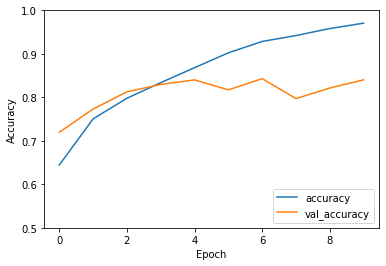

In [69]:

# plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

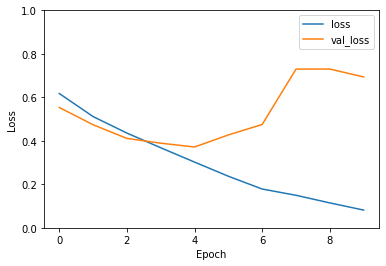

In [70]:
# plot the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.show()

In [ ]:
# evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_accuracy))

In [ ]:
# make a prediction
plt_1 = plt.figure(figsize=(15, 30))
ax = plt_1.subplots(1, 5)
i = 0

for image, label in test_dataset.take(50):
    res = model.predict(image)
    # pred_lable = int(res >= 0.5)
    pred_lable = np.argmax(res)    
    ax[i].axis('off')
    ax[i].set_title(class_names[pred_lable])
    ax[i].imshow(image[0])
    i +=1 

plt.show()

# Shap Explaination for Cat vs. Dog 

In [88]:
label.numpy()[0]

0